# Import Libraries

In [193]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
from tqdm.notebook import tqdm

from skimage.transform import resize

# Function Definitions

In [194]:
def load_images(path):
    images = []
    filenames = os.listdir(path)

    for filename in tqdm(filenames):
        image = cv2.imread(os.path.join(path, filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        images.append(image.astype(np.uint8))

    return images

# Load Images

In [195]:
main_dir = './subsampled_fruits_dataset'
train_dir = f'{main_dir}/train'
classnames = ['freshapples', 'freshbanana', 'freshoranges',
              'rottenapples', 'rottenbanana', 'rottenoranges']
idx2class = {i: classname for i, classname in enumerate(classnames)}

class_0 = load_images(f'{train_dir}/freshapples')
class_1 = load_images(f'{train_dir}/freshbanana')
class_2 = load_images(f'{train_dir}/freshoranges')
class_3 = load_images(f'{train_dir}/rottenapples')
class_4 = load_images(f'{train_dir}/rottenbanana')
class_5 = load_images(f'{train_dir}/rottenoranges')

  0%|          | 0/423 [00:00<?, ?it/s]

  0%|          | 0/395 [00:00<?, ?it/s]

  0%|          | 0/366 [00:00<?, ?it/s]

  0%|          | 0/585 [00:00<?, ?it/s]

  0%|          | 0/556 [00:00<?, ?it/s]

  0%|          | 0/398 [00:00<?, ?it/s]

# Plot Class Distribution

We can see that the classes are not balanced. We will need to take this into account when training and evaluating our model.

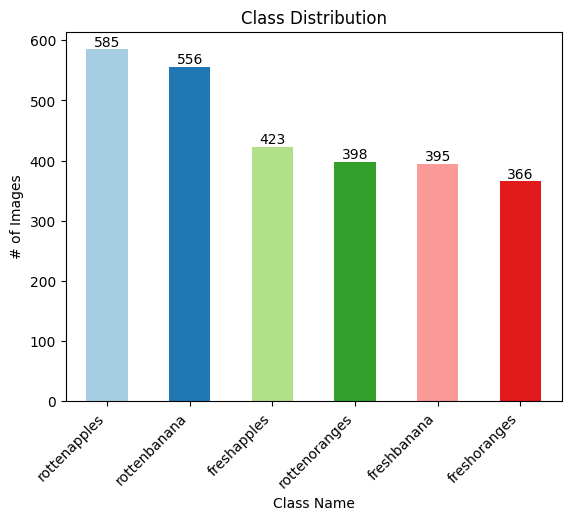

In [196]:
class_0_num_samples = len(class_0)
class_1_num_samples = len(class_1)
class_2_num_samples = len(class_2)
class_3_num_samples = len(class_3)
class_4_num_samples = len(class_4)
class_5_num_samples = len(class_5)

labels = np.array(
    [0] * class_0_num_samples +
    [1] * class_1_num_samples +
    [2] * class_2_num_samples +
    [3] * class_3_num_samples +
    [4] * class_4_num_samples +
    [5] * class_5_num_samples)

all_images = list(class_0) + list(class_1) + list(class_2) + \
    list(class_3) + list(class_4) + list(class_5)

df = pd.DataFrame(zip(all_images, labels), columns=['Image', 'Class'])
df['Class'] = df['Class'].map(idx2class)
bar = df['Class'].value_counts().plot(
    kind='bar', color=plt.get_cmap("Paired").colors,  # type: ignore
    title='Class Distribution',
    xlabel='Class Name',
    ylabel='# of Images')

plt.xticks(rotation=45, ha='right')

for p in bar.containers:  # type: ignore
    bar.bar_label(p, fmt='%d', label_type='edge')

In [197]:
def plot_images(images):
    plt.figure(figsize=(9, 9))

    for i, image in enumerate(images[0:25]):
        plt.subplot(5, 5, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(image)
        plt.suptitle("Original Dataset", fontsize=15)
    plt.show()

In [214]:
def extract_features(image):
    # convert to LAB image
    lab_image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)

    # split channels
    l_channel, a_channel, b_channel = cv2.split(lab_image)

    # blur the channel
    blur_image = cv2.GaussianBlur(b_channel, (5, 5), 0)

    # Apply Otsu thresholding to image
    ret, thresh = cv2.threshold(
        blur_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    opened = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

    contours, hierarchy = cv2.findContours(opened, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for i, cnt in enumerate(contours):
        # get contour area
        area = round(cv2.contourArea(cnt), 2)

        # get contour length (blob perimeter)
        perimeter = round(cv2.arcLength(cnt, True), 2)

        # circularity = 4 * pi * area / (perimeter)**2
        try:
            circularity = round(
                (4 * 3.14 * area) / (perimeter**2), 2)
        except ZeroDivisionError:
            circularity = 0

        # get contour hull and area (convexity)
        hull = cv2.convexHull(cnt, False)
        convex_area = cv2.contourArea(hull, True)

        try:
            convexity = round(area / convex_area, 2)
        except ZeroDivisionError:
            circularity = 0

    # Apply mask on image
    mask = (cv2.merge([opened, opened, opened]))
    segmented_image = 255 * (mask * image)

    # Color moments feature extraction
    red_mean, green_mean, blue_mean = np.mean(image, axis=(0, 1))
    red_std, green_std, blue_std = np.std(image, axis=(0, 1))

    R = image[:, :, 0]
    G = image[:, :, 1]
    B = image[:, :, 2]

    red_skew = np.mean((R - red_mean)**3) / (red_std**3)
    green_skew = np.mean((G - green_mean)**3) / (green_std**3)
    blue_skew = np.mean((B - blue_mean)**3) / (blue_std**3)

    red_kurt = np.mean((R - red_mean)**4) / (red_std**4)
    green_kurt = np.mean((G - green_mean)**4) / (green_std**4)
    blue_kurt = np.mean((B - blue_mean)**4) / (blue_std**4)

    hsv_img = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    h_mean, s_mean, v_mean = np.mean(hsv_img, axis=(0, 1))
    h_std, s_std, v_std = np.std(hsv_img, axis=(0, 1))

    H = hsv_img[:, :, 0]
    S = hsv_img[:, :, 1]
    V = hsv_img[:, :, 2]

    h_skew = np.mean((H - h_mean)**3) / (h_std**3)
    s_skew = np.mean((S - s_mean)**3) / (s_std**3)
    v_skew = np.mean((V - v_mean)**3) / (v_std**3)

    h_kurt = np.mean((H - h_mean)**4) / (h_std**4)
    s_kurt = np.mean((S - s_mean)**4) / (s_std**4)
    v_kurt = np.mean((V - v_mean)**4) / (v_std**4)
    
    feature_vector = {
        'area': area,
        'perimeter': perimeter,
        'circularity': circularity,
        'convexity': convexity,
        'red_mean': red_mean,
        'green_mean': green_mean,
        'blue_mean': blue_mean,
        'red_std': red_std,
        'green_std': green_std,
        'blue_std': blue_std,
        'red_skew': red_skew,
        'green_skew': green_skew,
        'blue_skew': blue_skew,
        'red_kurt': red_kurt,
        'green_kurt': green_kurt,
        'blue_kurt': blue_kurt,
        'h_mean': h_mean,
        's_mean': s_mean,
        'v_mean': v_mean,
        'h_std': h_std,
        's_std': s_std,
        'v_std': v_std,
        'h_skew': h_skew,
        's_skew': s_skew,
        'v_skew': v_skew,
        'h_kurt': h_kurt,
        's_kurt': s_kurt,
        'v_kurt': v_kurt
    }

    return segmented_image, feature_vector

# Driver Code

In [277]:
columns = ['class', 'area', 'perimeter', 'circularity', 'convexity', 'red_mean', 'green_mean', 'blue_mean', 'red_std', 'green_std', 'blue_std', 'red_skew', 'green_skew', 'blue_skew', 'red_kurt', 'green_kurt', 'blue_kurt', 'h_mean', 's_mean', 'v_mean', 'h_std', 's_std', 'v_std', 'h_skew', 's_skew', 'v_skew', 'h_kurt', 's_kurt', 'v_kurt']
features_df = pd.DataFrame(columns=columns)

segmented_images = []
for i, image in enumerate(tqdm(all_images)):
    # Apply segmentation and extract features
    segmented_image, features = extract_features(image)

    # Append segmented image to list
    segmented_images.append(segmented_image)

    # Append features to dataframe
    feature_vector = {'class': labels[i]}
    feature_vector.update(features)
    features_df = pd.concat([features_df, pd.DataFrame([feature_vector])], ignore_index=True)

features_df['class'] = features_df['class'].map(idx2class)

  0%|          | 0/2723 [00:00<?, ?it/s]

**Sanity Check!**

Number of segmented images: 2723
Number of features: 29
Number of samples: 2723
Number of unique classes: 6


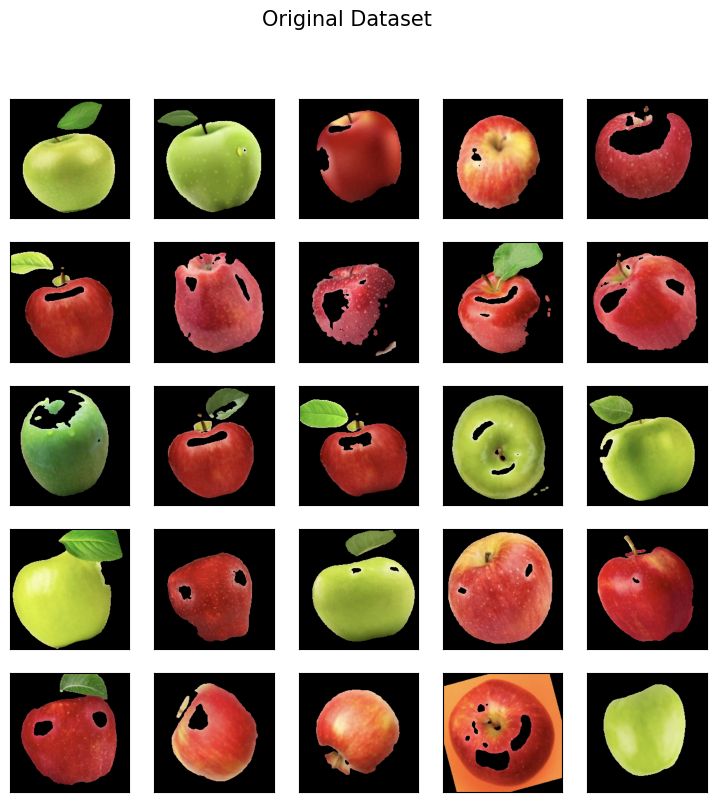

In [278]:
print(f"Number of segmented images: {len(segmented_images)}")
print(f"Number of features: {len(features_df.columns)}")
print(f"Number of samples: {len(features_df)}")
print(f"Number of unique classes: {len(features_df['class'].unique())}")
plot_images(segmented_images)

In [280]:
features_df.to_csv('fruits_dataset.csv', index=False)